### Imports

In [88]:
# data
from sklearn.datasets import fetch_mldata
import numpy as np

# models
from sklearn.linear_model import SGDClassifier

# model validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

In [8]:
# Getting the data 
mnist = fetch_mldata('MNIST original')

/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
# Getting dataset info
print(mnist)

# Split into data and labels
X, y = mnist['data'], mnist['target']

print(X.shape)
print(y.shape)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
(70000, 784)
(70000,)


<function matplotlib.pyplot.show(*args, **kw)>

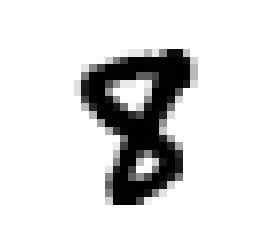

In [10]:
# Showing a sample of the dataset
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import random

random_int = random.randint(0, X.shape[0])

random_number = X[random_int].reshape(28, 28)
plt.imshow(random_number, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show

### Data prep

In [11]:
# shuffling the data 

shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

In [12]:
# 6000/1000 train test split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Developing as 5 identifier

Using a stochastic gradient descent model, we're going to build a model thatwill try to determine if an image is representing a number five.

In [13]:
# Creating a boolean mask for 5 and non-5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
# Training the SGD Classification model

sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

It's some other number...


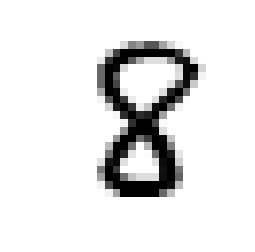

In [15]:
rand = random.randint(0, 10000)
X_example = X_test[rand]
y_example = y_test[rand]

%matplotlib inline

plt.imshow(X_example.reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')

if sgd_class.predict([X_example])[0]:
    print('It\'s a five!')
else:
    print('It\'s some other number...')

### Measuring the accuracy of the model

In [17]:
# Using cross-validation

# The outcome of this validation is usually 95% or better
# Thgat is mostly because 90% of the data is not 5
# Ther model is training on skewed data, therefore,
# accuracy is not the best measure for validation of the model

cross_val_score(sgd_class, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96720164, 0.96785   , 0.91519576])

In [18]:
# Getting the set of predictions from the model for analysis

y_train_pred = cross_val_predict(sgd_class, X_train, y_train_5)

In [22]:
# Generating the confusion matrix for the model's prediction

conf_mat = confusion_matrix(y_train_5, y_train_pred)
conf_mat

array([[52630,  1951],
       [ 1044,  4375]])

In [35]:
# Calculating precision and recall

# Precision - Out of all classified as 5's, those that actually were 5's
p = conf_mat[1][1] / (conf_mat[0][1] + conf_mat[1][1])

# Recall - Out of all 5's, those that were correctly classified
r = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

Precision: 69.16%
Recall: 80.73%


In [37]:
# Calculatin precision and recall with scikit learn

p = precision_score(y_train_5, y_train_pred)
r = recall_score(y_train_5, y_train_pred)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# We can also calculate the F1 score
# That is, a harmonic mean of precision and recall.

# This is a measure that get's higher the more similar precision and recall values are
f1 = f1_score(y_train_5, y_train_pred)

print(f'F1 score: {round(f1*100,2)}%')

Precision: 69.16%
Recall: 80.73%
F1 score: 74.5%


In [45]:
# In order to understand and modify the threshold value of the SGD classifier
# we can call it's `decision_function()` that will tell us the score
# of how likely the image represents a 5.
# Than we can make the decision ourselves and see how different measures change.

y_scores = sgd_class.decision_function([X_example])
y_scores

# SGD classifier uses a threshold value of 0 by defaut
threshold = 0
print(y_scores > threshold)

# We can now change the threshold
threshold = 200000
print(y_scores < threshold)


[False]
[ True]


In [57]:
# The score for each prediction can be calculated by the cross_valid_predict()

y_scores = cross_val_predict(sgd_class, X_train, y_train_5, cv=3, method='decision_function')

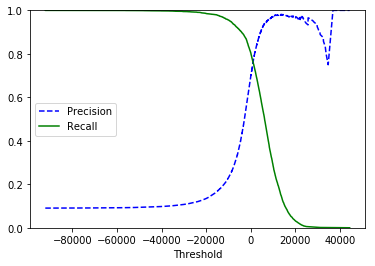

In [60]:
# We can plot different precision and recall values depending on different threshold values

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim(0, 1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Noticeably, the precision curve is a lot less smooth than the recall one
# This is because when we increase the threshhold, we eliminate some of the True positives
# and therefore, te overall precision dives down a little.
# It goes back up again as we get past more and more of false positives

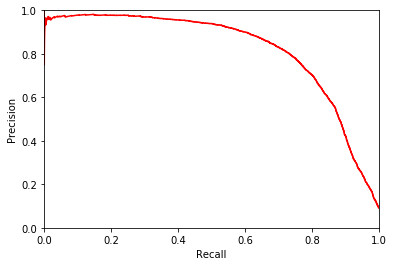

In [62]:
# It's also possible to plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plot_precision_vs_recall(precisions, recalls)

In [66]:
# Depending on the project, we might want a specific precision value
# Let's say that we want the precision value of 90%.
# Now we can select a threshold value that will suit this.
# On the first plot, we can see that the precision of 90% is at about 30000 threshold value

y_train_pred_90 = (y_scores > 30000)

# now we can veirfy the precision and check the recall
p = precision_score(y_train_5, y_train_pred_90)
r = recall_score(y_train_5, y_train_pred_90)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')


Precision: 91.67%
Recall: 0.2%


In [74]:
# Because of choosing the score of 30000, we got a high precision score
# however, the recall score is near 0, which means that out of all 5's
# only 0.2% got classified as 5's!

# There's a lower threshold score we can choose that's also around 90% recall value ~ 4500
y_train_pred_90 = (y_scores > 4500)

p = precision_score(y_train_5, y_train_pred_90)
r = recall_score(y_train_5, y_train_pred_90)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# Whith this score, we can see that most of the 5's have been identified correctlty

Precision: 90.07%
Recall: 59.92%


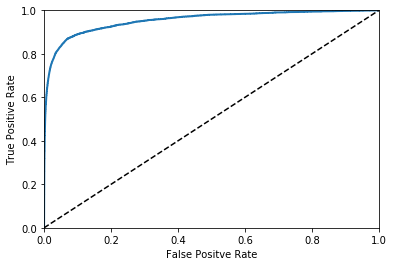

In [84]:
# We can also plot the ROC curve
# This shows us the change between the true and false positive rates.

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc(tpr, fpr, thresholds):
    plt.plot(fpr, tpr, linewidth=2)
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])

plot_roc(tpr, fpr, thresholds)

In [87]:
# we can compare this way a number of models by calculating the Area Under the Curve (AUC)

auc = roc_auc_score(y_train_5, y_scores)
print(f'AUC: {auc}')

AUC: 0.9536313683955632
